By adrianty & sondrewo

# Table of contents:

* Implicit assumptions and discussion
* Model Development
    * Hypothesis and heuristics
    * Exp 1: Comparing different classification models
        - Testing different smoothing parameters
        - Estimating actual performance of MultinomialNB
    * Exp 2: Feature Selection
    * Exp 3: Comparison with RandomBanker.py
* Fairness
    * Sensitive variables
    * p%-metric
    * Exp 4: p%-score of sensitive variables
    * The balance between utility and fairness
    * Exp 5: How sensitive variables affect total utility
* Reproducibility and reliability
* Privacy
* Discussion
* Results

\pagebreak

# Implicit assumptions of the data <a id="implicit_assumptions"></a>

The data was already labeled with some named columns in the provided TestLending script. We still decided to do some explorative testing, to see if we could use some heuristics to develop some additional understanding of the data. We found out that there were many more elements that were labelled with <em>2</em>, which is described in the documentation as <em>bad</em>, than there were those that were labelled with <em>1</em>, or <em>good</em>. Further inspection revealed that the average amount for the <em>bad</em> loans were quite a lot higher than the <em>good</em> ones. This could suggest that the data is taken from a position in time where the <em>bad</em> loans have already defaulted, and the <em>good</em> ones are in the process of being paid off.

This of course would make modelling extremely difficult, as we would have to normalize the amounts for the duration remaining. This would be extremely speculative and probably not make for good generalization, so we make the assumption that this is not the case, and that the duration and amount listed are initial values.

# Model development <a id="model_dev"></a>

## Intro <a id="hypothesis"></a>

We started our model development by inspecting the different columns in the data set, identifying both numerical and discrete  features. As is well known, the Naive Bayes classifier supports catergorical features natively and can be adjusted to use numerical ones as well. Thus, we formulated the following hypothesis:

<strong>H</strong><sub>0</sub> : The Multinomial Naive Bayes classifier will perform well

We then attempted to falsify this hypothesis (Exp 1) by testing out different models: Logistic regression, KNN, BernoulliNB, AdaBoost with Decision Tree and a simple multi-layered perceptron (MLP).

## Setup

In [1]:
class AdrianSondreBanker:
    def __init__(self, MODEL):
        self.model = MODEL
    
    def fit(self, X, y):
        self.data = [X, y]
        self.model.fit(X, y)

    def set_interest_rate(self, rate):
        self.rate = rate
        return

    def predict_proba(self, x):
        """
        Gets the probability distribution over two classes. 
        Reshape is done to get the result as a simple 1d array.
        """
        return self.model.predict_proba(np.array(x).reshape(1, -1))[0]

    def expected_utility(self, x, action):
        """
        Calculates the expected utility of an individual. Uses the formula
        
        utility = amount_of_loan * (1 + lend_rate)^duration_of_loan
        """
        
        utility = (x["amount"] * ((1 + self.rate) ** x['duration'])) - x["amount"]
        
        U = np.matrix(f"0 0; {utility} {x['amount'] * -1}")

        # get the probabilities of the classes (will pay, wont pay)
        probs = self.predict_proba(x)
        
        # get the index of the highest probability - 0 if wont pay, 1 if will pay
        repaid = np.where(probs == max(probs))

        return U[action, repaid]

    


    def get_best_action(self, x):
        """
        Decide whether to give a loan to some individual x.
        
        Returns:
            the index of the highest expected utility - 0 if loan denied, 1 if loan given
        """
        util = [self.expected_utility(x, a) for a in [0,1]]
        return util.index(max(util))

In [2]:
from sklearn.naive_bayes import MultinomialNB 
from sklearn.naive_bayes import BernoulliNB 
from sklearn.naive_bayes import GaussianNB 
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
import pandas
import math
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import random_banker
%matplotlib inline

In [3]:
VALID_PATH = "./data/credit/D_valid.csv"
TRAIN_PATH = "./data/credit/D_train.csv"
TEST_PATH = "./data/credit/D_test.csv"
interest_rate = 0.017

def get_data(path, drop_cols=None):
    """
    Fetches a dataset with the desirable features. Discussion on the 
    different datasets can be found below.
    """
    features = ['checking account balance', 'duration', 'credit history',
                'purpose', 'amount', 'savings', 'employment', 'installment',
                'marital status', 'other debtors', 'residence time',
                'property', 'age', 'other installments', 'housing', 'credits',
                'job', 'persons', 'phone', 'foreign']
    target = 'repaid'

    df = pandas.read_csv(path, sep=' ',
                         names=features+[target])
    if drop_cols:
        df = df.drop(["marital status", "residence time", "age",
        "other installments", "persons", "phone", "foreign"], axis=1)
    numerical_features = ['duration', 'age', 'residence time', 'installment', 'amount', 'persons', 'credits']
    quantitative_features = list(filter(lambda x: x not in numerical_features, [x for x in df.columns if x!="repaid"]))
    X = pandas.get_dummies(df, columns=quantitative_features, drop_first=True)
    encoded_features = list(filter(lambda x: x != target, X.columns))
    return X, encoded_features, target

In [4]:
def test_decision_maker(X_test, y_test, interest_rate, decision_maker):
    """
    Default standard test - copied from TestLending.py
    """
    n_test_examples = len(X_test)
    utility = 0

    ## Example test function - this is only an unbiased test if the data has not been seen in training
    total_amount = 0
    total_utility = 0
    decision_maker.set_interest_rate(interest_rate)
    for t in range(n_test_examples):
        action = decision_maker.get_best_action(X_test.iloc[t])
        good_loan = y_test.iloc[t] # assume the labels are correct
        duration = X_test['duration'].iloc[t]
        amount = X_test['amount'].iloc[t]
        # If we don't grant the loan then nothing happens
        if (action==1):
            if (good_loan != 1):
                utility -= amount
            else:
                utility += amount*(pow(1 + interest_rate, duration) - 1)
        total_utility += utility
        total_amount += amount
    return utility, total_utility/total_amount

In [5]:
### Do a number of preliminary tests by splitting the data in parts
def run_test(models, X, encoded_features, target, n_tests=100, flag=None):
    '''
    Default testing of a (or multiple) model(s), mostly taken from TestLending.py
    
    args:
        models (dict): dictionary of models to test on. key=str (name of model), value=model
    returns:
        results: dictionary of the total utility and avg investment return per n, per model
    '''
    results = {}
    n_tests = n_tests
    for name, model in models.items():
        n_tests = n_tests if name not in ("KNN", "BernoulliNB", "MultinomialNB") else 1
        decision_maker = AdrianSondreBanker(model)
        utility = 0
        investment_return = 0
        for iter in range(n_tests):
            if flag is not None:
                X_train, y_train = X[encoded_features], X[target]
                X_test, y_test = flag[encoded_features], flag[target]
            else:
                X_train, X_test, y_train, y_test = train_test_split(X[encoded_features], X[target], test_size=0.2)
            decision_maker.set_interest_rate(interest_rate)
            decision_maker.fit(X_train, y_train)
            Ui, Ri = test_decision_maker(X_test[encoded_features], y_test, interest_rate, decision_maker)
            utility += Ui
            investment_return += Ri
        results[name] = [math.floor((utility / n_tests) * 100)/100.0, math.floor((investment_return / n_tests) * 100)/100.0]
    return results, decision_maker

## Exp 1: Comparing different classification models: <a id="comparing_different"></a>

In [6]:
def run_tests_for_all_classifiers(path, flag=False, flip=False):
    """
    Compare results from different classifiers, using the default test above.
    
    Keyword arguments in place to experiment with different datasets.
    """
    if flag:
        if flip:
            path1 = VALID_PATH
            path2 = TRAIN_PATH
        else:
            path1 = TRAIN_PATH
            path2 = VALID_PATH
        X, encoded_f, tar = get_data(path1)
        X_te, _, _ = get_data(path2)
    else:
        X, encoded_f, tar = get_data(path)
        X_te = None
    results = run_test({"KNN": KNeighborsClassifier(n_neighbors=31),
                    "BernoulliNB": BernoulliNB(),
                    "MultinomialNB": MultinomialNB(),
                    "Log.regression": LogisticRegression(max_iter=1500),
                    "Neural Net": MLPClassifier(alpha=1, max_iter=1000)}, X, encoded_f, tar, flag=X_te)
    return pandas.DataFrame(results[0].items(), columns=["Model", "Total Utility, Avg Investment Return"])

### Results of different models

In [7]:
results = run_tests_for_all_classifiers("", flag=True)
results

,Model,"Total Utility, Avg Investment Return"
0,KNN,"[13889323.65, 442.04]"
1,BernoulliNB,"[17527135.64, 566.17]"
2,MultinomialNB,"[23827002.45, 733.78]"
3,Log.regression,"[9936292.32, 278.17]"
4,Neural Net,"[14468034.8, 498.6]"


In [8]:
def get_accuracy_for_models(path, flag=None, flip=False):
    """
    Tests different models for their accuracies. 
    
    Keyword arguments in place to experiment with different datasets.
    """
    if flag:
        if flip:
            path1 = VALID_PATH
            path2 = TRAIN_PATH
        else:
            path1 = TRAIN_PATH
            path2 = VALID_PATH
        X, encoded_f, tar = get_data(path1)
        X_tr = X[encoded_f]
        y_tr = X[tar]
        X_nd, _, _ = get_data(path2)
        X_te = X_nd[encoded_f]
        y_te = X_nd[tar]
    else:
        X, encoded_f, tar = get_data(path)
        X_tr, X_te, y_tr, y_te = train_test_split(X[encoded_f], X[tar])
    scores = []
    for model in [
        KNeighborsClassifier(n_neighbors=31),
        BernoulliNB(),
        MultinomialNB(),
        LogisticRegression(max_iter=1500),
        MLPClassifier(alpha=1, max_iter=1000)]:
        model.fit(X_tr, y_tr)
        scores.append(model.score(X_te, y_te))
    return scores

In [9]:
accuracies = get_accuracy_for_models(TRAIN_PATH)
accuracies

[0.664, 0.74, 0.64, 0.684, 0.676]

In [10]:
def plot_utility_vs_accuracy(accuracies, utilities):
    """
    Plots a scatterplot for utilities and accuracies of different models. 
    """
    colors = ["r", "b", "g", "y", "orange"]
    model_names = ["KNN", "BernoulliNB", "MultinomialNB", "LogReg", "MLP"]
    acc_utils = zip(accuracies, [r[0] for r in utilities["Total Utility, Avg Investment Return"]])
    for i, (model, (accuracy, utility)) in enumerate(zip(model_names, acc_utils)):
        plt.plot([accuracy], [utility], "s", ms=10, c=colors[i], label=model)
    plt.xlabel("Accuracy")
    plt.ylabel("Utility")
    plt.legend()

In [11]:
def utility_vs_accuracy_for_set(path, flag=None, flip=False):
    utilities = run_tests_for_all_classifiers(path, flag=flag, flip=flip)
    accuracies = get_accuracy_for_models(path, flag=flag, flip=flip)
    plot_utility_vs_accuracy(accuracies, utilities)

\pagebreak

### Plots of accuracy vs utility for different models on different datasets

#### Validation set

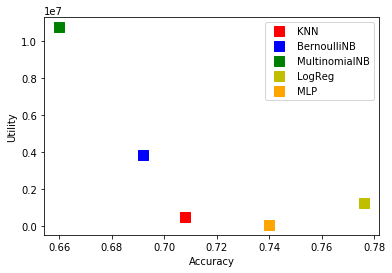

In [12]:
utility_vs_accuracy_for_set(VALID_PATH)

We can see a clear linear relation between all the classifiers, except for the multinomial Naïve Bayes. This could suggest that the dataset shows tendencies favourable to the multinomial NB, and might not be the best for generalization. Therefore, we also test it on the validation set alone:

\pagebreak

#### Training set

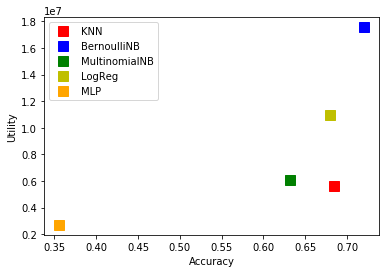

In [13]:
utility_vs_accuracy_for_set(TRAIN_PATH)

These results may suggest that the discussion above were well-founded, and that MultinomialNB may not be the best classifier for potential further testing. For further testing, we train the classifiers on the train dataset and test them on the validation set, which should give a better estimate of their performances:

\pagebreak

#### Training and validation set combined

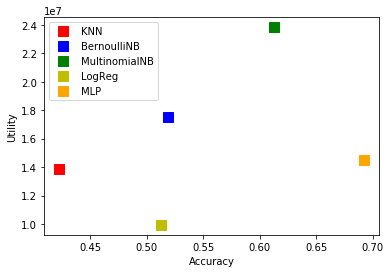

In [14]:
utility_vs_accuracy_for_set("", flag=True)

We see that once again, the multinomial NB looks to be superior. For a final test, we flip the training process, and train the models on the validation set, and test them on the training set:

\pagebreak

#### Traning and validation set combined and flipped

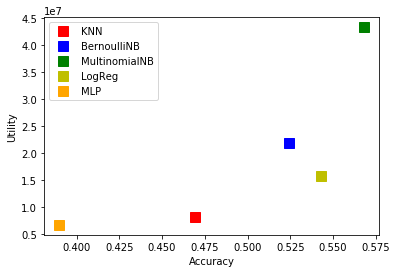

In [15]:
utility_vs_accuracy_for_set("", flag=True, flip=True)

We can conclude that in terms of utility, there is no contest. The MultinomialNB-classifier seems to be a much better fit on our dataset than the other ones we tested.

\pagebreak

## Exp 1.1 Testing for multiple smoothing parameters <a id="smoothing"></a>

In [75]:
def test_smoothings(path):
    """
    Hyperparameter search for MultinomialNB.
    """
    X, encoded_f, tar = get_data(path)
    params = np.linspace(0.01, 10, 10) #[0.1, 0.5, 1.0, 10.0, 100.0] 
    models = {}
    results = None
    for i in params:
        models[i] = MultinomialNB(alpha=i)
    results,_ = run_test(models, X, encoded_f, tar)
    return results
    

In [19]:
res = test_smoothings(VALID_PATH)

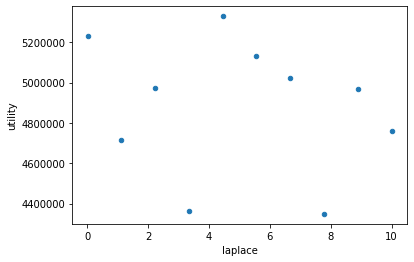

In [20]:
res_formatted = {key:value[0] for key,value in res.items()}
df = pandas.DataFrame(res_formatted.items(), columns=["laplace","utility"])
df.plot.scatter(x="laplace", y="utility")


In [76]:
tr_res = test_smoothings(TRAIN_PATH)

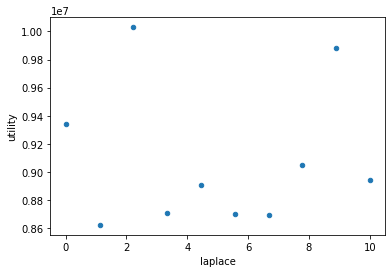

In [78]:
tr_res_formatted = {key:value[0] for key,value in tr_res.items()}
df = pandas.DataFrame(tr_res_formatted.items(), columns=["laplace","utility"])
df.plot.scatter(x="laplace", y="utility")


The results from the two plots suggest that there is little correlation between the hyperparameter and the result, so we keep the default of alpha=1.

## Results of Exp 1:

Based on these results, we chose to keep our hypothesis H<sub>0</sub> and continue the development using the Multinomial NB model as a baseline, using the default laplace smoothing of `1.0`. Testing different smoothing parameters over time did not affect the utility.

<b> Assumption 1 </b>: 
    Since the results for Multinomial NB was that much better than for KNN, we assumed that changing the amount of neighbours would not out-perform NB and decided to only test for `k=floor(sqrt(n))=31` (a common approach for K selection for KNN)


## Estimating actual performance of Multinomial Naive Bayes <a id="actual_performance"></a>

Utilizing a generative classifier such as Multinomial NB provides one practical advantage over using discriminative models, is that the result provided stays constant for a given train and development set. We might still want to see how the model would perform with some slight differences in the data, by using different amounts of data at train and development time, to get an idea of how well the model generalizes.

In [21]:
def avg_for_n_runs(X, n, encoded_features, target, model):
    """
    Compact function that fetches utility scores and averages for n runs.
    """
    utis, avg = [], []
    for _ in range(n):
        X_tr, X_te, y_tr, y_te = train_test_split(X[encoded_features], X[target], test_size=0.2)
        banker = model
        banker.fit(X_tr, y_tr)
        uti, div = test_decision_maker(X_te, y_te, interest_rate, banker)
        utis.append(uti)
        avg.append(div)
    return utis, avg

We have experimented with both the provided D_valid and D_train datasets, as they have quite different content. in the D_valid set, about 1/3 of the individuals are granted a loan, while in D_train, about 2/3 are. We are leaving the D_test set untill we feel like we are completely finished with the model development, so that we have some fundament to evaluate how well our model can generalize.

In [22]:
from sklearn.utils import resample

In [23]:
18:30def get_samples(dataset, model=None, info=None):
    """
    Helper function to fetch resampling of a set of results. 
    
    Args:
        dataset (str): the name of the dataset.
        info (tuple): A tuple of a dataset, features, and the target value name
    Returns:
        a list of averages of resampled results.
    """
    if not info:
        X, encoded_f, tar = get_data(f"./data/credit/D_{dataset}.csv")
    else:
        X, encoded_f, tar = info
    n = 500
    m = model if model is not None else AdrianSondreBanker(MultinomialNB())
    m_uti, m_avg = avg_for_n_runs(X, n, encoded_f, tar, m)
    m_uti = np.array(m_uti)
    return [resample(m_uti).sum()/n for _ in range(10000)]

\pagebreak


### Histograms of utility for different datasets

In [24]:
def create_hist_for_valid():
    """
    Create a histogram for the D_valid dataset.
    """
    data = [round(x/1000000,3) for x in get_samples("valid")]
    plt.hist(data, bins=20)
    plt.xlabel('utility')
    plt.ylabel('count')
    plt.title('Histogram of utilities - D_valid')

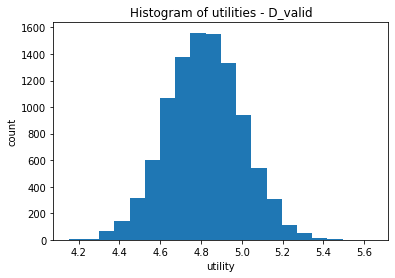

In [25]:
create_hist_for_valid()

A histogram of the total utility of our model over 500 runs, resampled 1000 times. The model is trained on the D_valid data set. There is a clear gaussian tendency of the data, with the average being around 4.8 million.

\pagebreak

In [26]:
def create_hist_for_train():
    """
    Create a histogram for the D_train dataset.
    """
    data = [round(x/1000000, 3) for x in get_samples("train")]
    plt.hist(data, bins=20)
    plt.xlabel("utility")
    plt.ylabel("count")
    plt.title("Histogram of utilities - D_train")

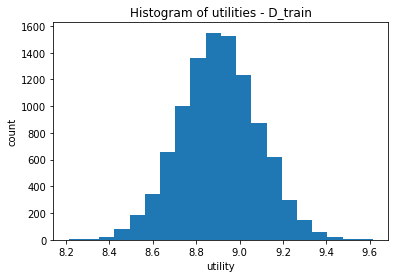

In [27]:
create_hist_for_train()

A histogram like the one above, but on the D_train set The same tendencies can be found, but the numbers are likely different due to the one above due to the difference in class distributions - but we will put this to the test in the next section.

\pagebreak

In [28]:
def create_hist_for_both():
    """
    Create a histogram for both the D_valid and D_train datasets.
    """
    X, encoded_f, tar = get_data(VALID_PATH)
    X_t, _, _ = get_data(TRAIN_PATH)
    X = pandas.concat([X, X_t])
    data = get_samples("", info=(X, encoded_f, tar))
    plt.hist(data, bins=20)
    plt.xlabel("utility")
    plt.ylabel("count")
    plt.title("Histogram of utilities - both sets")

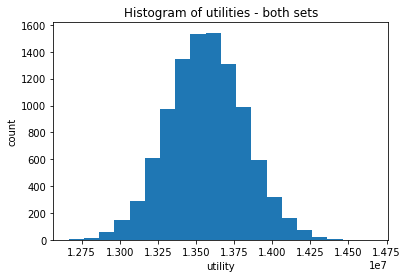

In [29]:
create_hist_for_both()

We see that the utility is increasing proportionally with the size of the dataset, meaning that the model likely does not benefit from the extra data. This might be because some of the features we are using are diffusing the generalization process. We will explore that in the following section.

\pagebreak

## Exp 2:  Feature selection <a id="feature_selection"></a>

Next, we decided to try forward stepwise feature selection, based on the lab session by Dirk Hesse, using the baseline model.

In [30]:
from sklearn.model_selection import cross_val_score
from random import sample

### Feature Selection

In [31]:
def stepwise_selection(features, target, classifier=MultinomialNB()): #Credit: Dirk's notebooks
    """
    Extract the best 0 > N > 12 features from the dataset.
    
    Args:
        features (pandas DataFrame): The dataset
        target (str): The target column of the dataset
        classifier (sklearn model): some classifier
    Returns:
        a list of the best scores, and a list of the best features.
    
    """
    global_best_features = []
    global_best_scores = []
    global_best_score = pandas.Series([0])
    for N in range(1, 12):
        columns = list(filter(lambda x: x != "repaid", features.columns))
        columns = sample(columns, len(columns))
        selected_features = []
        scores = []
        while len(selected_features) < N:
            best_score = pandas.Series([0])
            best_feature = None
            for feature in columns:
                score = cross_val_score(classifier,
                                       features[selected_features + [feature]], features[target])
                if score.mean() > best_score.mean():
                    best_feature = feature
                    best_score = score
            columns.remove(best_feature)
            selected_features.append(best_feature)
            scores.append(best_score)
        best_scores = list(sorted(scores, reverse=True, key=lambda x: x.mean()))[0]
        if np.array(best_scores).mean() > np.array(global_best_score).mean():
            global_best_features = selected_features 
            global_best_score = np.array(scores).mean()
        global_best_scores.append(best_scores)
    return global_best_scores, global_best_features

In [32]:
def create_hist_for_stepwise(path=VALID_PATH):
    """
    Create a histogram using the stepwise function.
    """
    if isinstance(path, str):
        X, encoded_f, tar = get_data(path)
    elif isinstance(path, bool):
        X, encoded_f, tar = get_data(VALID_PATH)
        X_t, _, _ = get_data(TRAIN_PATH)
        X = pandas.concat([X, X_t])
    scores, selected_features = stepwise_selection(X, tar)
    if "amount" not in selected_features:
        selected_features = selected_features + ["amount"]
    if "duration" not in selected_features:
        selected_features = selected_features + ["duration"]
    data = get_samples("", info=(X, selected_features, tar))
    data = [round(x/1000000,3) for x in data]
    plt.hist(data, bins=20)
    plt.xlabel("utility")
    plt.ylabel("count")
    plt.title("Histogram with selected features")
    return scores, selected_features

\pagebreak

### Histograms of utility and frequency count for different datasets

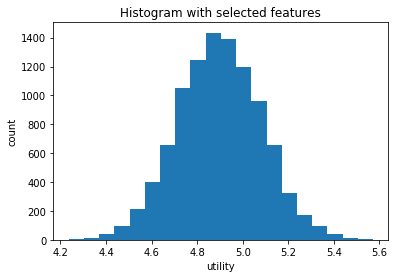

In [33]:
scores, selected_features = create_hist_for_stepwise()

The fewer selected features have seemingly little effect on the valid dataset, as the numbers are very similar to the above figure.

\pagebreak

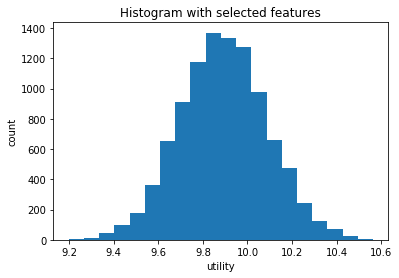

In [34]:
train_scores, train_selected_features = create_hist_for_stepwise(path=TRAIN_PATH)

These values however are distinguishly higher than before. Using the train dataset, it would seem that higher utility is achievable by removing some of the features.

\pagebreak

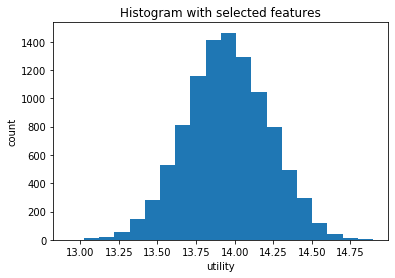

In [35]:
both_scores, both_selected_Features = create_hist_for_stepwise(path=True)

We see that the values for both sets are very similar for both sets, albeit more concentrated around the average. It is clear that there is little extra information to extract by using both datasets.

We can plot some graphs to visualize how the model behaves when trained on different datasets.

\pagebreak

### Plots of number of features vs accuracy scores

#### Validation set

Text(0, 0.5, 'Accuracy')

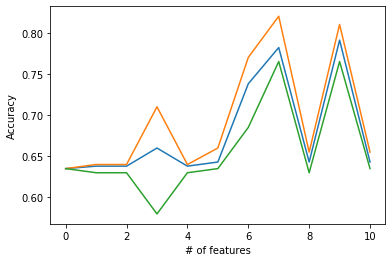

In [36]:
plt.plot([s.mean() for s in scores])
plt.plot([s.max() for s in scores])
plt.plot([s.min() for s in scores])
plt.xlabel("# of features")
plt.ylabel("Accuracy")

\pagebreak

#### Training set

Text(0, 0.5, 'Accuracy')

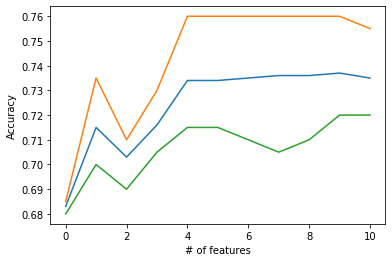

In [37]:
plt.plot([s.mean() for s in train_scores])
plt.plot([s.max() for s in train_scores])
plt.plot([s.min() for s in train_scores])
plt.xlabel("# of features")
plt.ylabel("Accuracy")

\pagebreak

#### Training and validation sets combined

Text(0, 0.5, 'Accuracy')

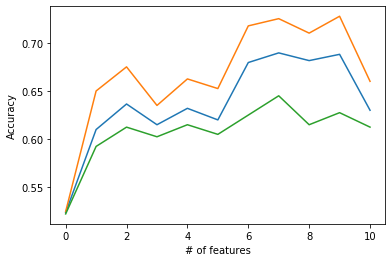

In [38]:
plt.plot([s.mean() for s in both_scores])
plt.plot([s.max() for s in both_scores])
plt.plot([s.min() for s in both_scores])
plt.xlabel("# of features")
plt.ylabel("Accuracy")

## Results of Exp 2:

We can see that the model is behaving differently to different amounts of features, but for most the differences between >4 and <10 are not really indicative of anything - possibly except for the model trained on the D_train-dataset in [Fig 2](#fig_2). Which is interesting, considering that it was the only model that performed better with fewer parameters. There might be a sweet spot beyond the values we tested for.

\pagebreak

## Exp 3: Comparison with RandomBanker.py <a id="comparison"></a>

In [39]:
def run_test_single_model(X, features, target, maker):
    """
    Tests a decision maker given a model and dataset.
    """
    res = []
    decision_maker = maker
    utility = 0
    investment_return = 0
    n_tests = 100
    for iter in range(n_tests):
        X_train, X_test, y_train, y_test = train_test_split(X[features], X[target], test_size=0.2)
        decision_maker.set_interest_rate(interest_rate)
        decision_maker.fit(X_train, y_train)
        Ui, Ri = test_decision_maker(X_test, y_test, interest_rate, decision_maker)
        utility += Ui
        investment_return += Ri
    
    res.append(math.floor((utility / n_tests) * 100)/100.0)
    res.append(math.floor((investment_return / n_tests) * 100)/100.0)
    return res

In [40]:
def compare_models():
    """
    Compares different decision makers.
    """
    comp_test = {}
    for i in ["train", "valid", "both"]:
        if i == "train":
            X, features, tar = get_data(TRAIN_PATH)
        elif i == "valid":
            X, features, tar = get_data(VALID_PATH)
        else:
            X, features, tar = get_data(VALID_PATH)
            X_t, _, _ = get_data(TRAIN_PATH)
            X = pandas.concat([X, X_t])
        comp_test[f"Random banker_{i}"] = run_test_single_model(X, features, tar, random_banker.RandomBanker())
        comp_test[f"AdrianSondreBanker_{i}"] = run_test_single_model(X, features, tar, AdrianSondreBanker(MultinomialNB()))
    return pandas.DataFrame(comp_test.items(), columns=["Model", "Total Utility, Avg Investment Return"])

In [41]:
def compare_dists():
    """
    Plots histograms for the utility distributions of our model and the random banker provided.
    """
    data = [round(x/1000000, 3) for x in get_samples("train", AdrianSondreBanker(MultinomialNB()))]
    data_random = [round(x/1000000, 3) for x in get_samples("train", random_banker.RandomBanker())]
    plt.hist(data, bins=20, alpha=0.5, label='AdrianSondreBanker')
    plt.hist(data_random, bins=20, alpha=0.5, label='RandomBanker')
    plt.legend(loc='upper right')
    plt.title("Distribution of utility over N=500 runs")
    plt.xlabel("Utility")
    plt.ylabel("Frequency of outcome")   
    plt.show()
    

### Simple table comparison

In [42]:
compare_models()

,Model,"Total Utility, Avg Investment Return"
0,Random banker_train,"[5414824.57, 131.65]"
1,AdrianSondreBanker_train,"[9005614.12, 220.79]"
2,Random banker_valid,"[570901.76, 16.5]"
3,AdrianSondreBanker_valid,"[4975550.84, 124.54]"
4,Random banker_both,"[6609834.23, 154.81]"
5,AdrianSondreBanker_both,"[13765941.31, 351.09]"


\pagebreak

### Histogram of utility for RandomBanker v.s AdrianSondreBanker

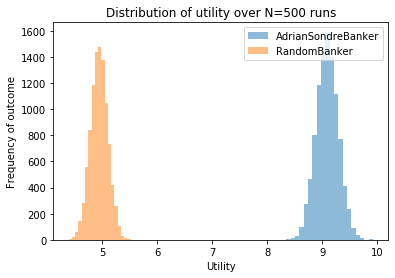

In [43]:
compare_dists()

## Results of Exp 3

The table above shows that our model performed better than the random banker module by quite a substantial amount. From the histogram, the distribution over 500 runs are also seperated by quite a high amount of utility. We can therefore conclude that our model performs better than the RandmBanker module.

\pagebreak

# Fairness <a id="fairness"></a>

In [44]:
def get_df_with_gender(df):
    #male = 0, female = 1
    df["gender"] = np.where((df["marital status_2"] + df["marital status_5"] == 1), 1, 0)
    return df

def get_over_age(df):
    #over = 1, under = 0
    df["over60"] = np.where((df["age"] >= 60), 1, 0)
    return df

In [45]:
#Creating some baselines to use in this section
X, encoded_features, target = get_data(TRAIN_PATH)
X = get_df_with_gender(X)
X = get_over_age(X)
X_train, X_test, y_train, y_test = train_test_split(X, X[target], test_size=0.2)
model = MultinomialNB() #use our baseline
model.fit(X_train, y_train)
None

## Sensitive variables <a id="fairness_sensitive"></a>

We identified primarily three sensitive variables in the data: gender (calculated from the marital status column), foreign worker status, and age. Ensuring that our model performs well – without discriminating on these variables – is crucial. Failing to do so might hinder its deployment. In order to more accurtaly test for disparate treatment in regard to age, we constucted a new feature out of the original data: `over60` - a binary indicating whether or not a single record was older than 60.

What follows is an attempt to quantify fairness, defined here, somewhat holisticly, as sensitive variables that should not influence the predictions of the model. Then, we try to optimise our model so that we have a reasonable tradeoff between utility and fairness.

## Introducing the p-percent metric <a id="fairness_p"></a>

We wanted to quantitatively measure fairness in our model. One way to do that is through the p-percent metric (Zafar et.al, 2017):

$$ p\%score=min ( \frac{𝑃(𝑦̂ =1|𝑧=1)}{𝑃(𝑦̂ =1|𝑧=0)}, \frac{𝑃(𝑦̂ =1|𝑧=0)}{𝑃(𝑦̂ =1|𝑧=1)})$$ 

The method gives us a measure on the demographic parity of our model. We wanted the rate of positive outcomes to be equal for our sensitive variables: `gender`, `over60` and `foreign_worker2`. 
According to Zafar et.al (2017), we can say that a model satisifes the criterion of disparate treatment if the ratio between the percentage of applicants with and without the sensitive attribute is no less than 80:100 in regard to the output variable.

<strong> The table below calculates the p-percent score for gender, foreign worker status and age(over 60): </strong>


In [46]:
from sklego.metrics import p_percent_score

In [47]:
def get_p_scores(features):
    res = {}
    for f in features:
        p = (p_percent_score(sensitive_column=f)(model, X))
        res[str(f)] = p
    return res

### Exp 4: P-Percent score for Foreign worker status, gender and age <a id="fairness_exp4"></a>

In [48]:
res = get_p_scores(["foreign_2","gender", "over60"])
df = pandas.DataFrame(res.items(), columns=["Feature", "P-score"])
df

,Feature,P-score
0,foreign_2,0.931412
1,gender,0.936638
2,over60,0.802335


### Exp 4 Results:

Both the foreign worker and gender feature are well above the acceptable threshold of 80%.
The "over60" feature, however, failed to meet the criteria – indicating that being over 60 years of age actually influences the output of the classification, which according to our definition of fairness should not happen. Any use of this model should take this deficiency into account.

## The balance between utility and fairness <a id="fairness_balance"></a>

In [49]:
def sample_run(X, encoded_f, tar, model, n=1000):
    """
    generates samples.
    """
    m_uti, m_avg = avg_for_n_runs(X, n, encoded_f, tar, model)
    m_uti = np.array(m_uti)
    return [resample(m_uti).sum()/n for _ in range(10000)]    

In [50]:
def compare_fairness(column_to_drop, gender=False):
    """
    Creates histogram over the distribution of utility with and without a provided column.
    """
    X, encoded_features, target = get_data(TRAIN_PATH)
    if gender:
        X = get_df_with_gender(X) #need to actually create this column out of other features (marital status)
        X_no_variable = X.copy()
        X_no_variable.drop([column_to_drop], axis=1)
    else:
        X_no_variable,_,_ = get_data(TRAIN_PATH)
        X_no_variable.drop([column_to_drop], axis=1)
    data = [round(x/1000000, 3) for x in sample_run(X, encoded_features, target, AdrianSondreBanker(MultinomialNB()))]
    data_no_var = [round(x/1000000, 3) for x in sample_run(X_no_variable, encoded_features, target, AdrianSondreBanker(MultinomialNB()))]
    
    plt.hist(data, bins=20, alpha=0.5, label='With ' + column_to_drop)
    plt.hist(data_no_var, bins=20, alpha=0.5, label='Without ' + column_to_drop)
    plt.legend(loc='upper right')
    plt.title("Distribution of utility over N=1000 runs")
    plt.xlabel("Utility (in millions)")
    plt.ylabel("Frequency of outcome")   
    plt.show()

### Exp 5: Total average utility with and without sensitive variables <a id="fairness_exp5"></a>

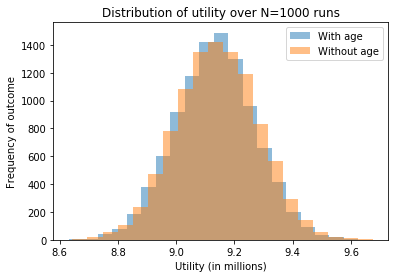

In [51]:
compare_fairness("age")

\pagebreak

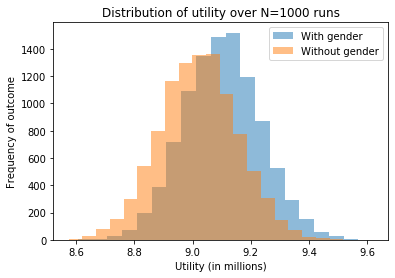

In [52]:
compare_fairness("gender", gender=True)

\pagebreak

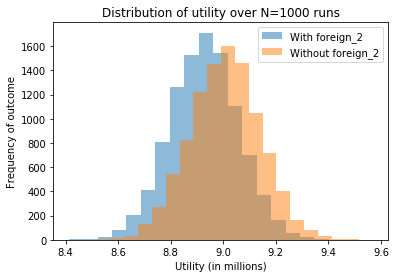

In [53]:
compare_fairness("foreign_2")

### Exp 5 Results

Overall, the probability mass of the utility distribution leans more to the left when allowed to classify based on gender, age and foreign worker status. Therefore, it might be the case that it is better overall, both in regards to utility and fairness, to disregard these variables in training and production. 

\pagebreak

# Reproducibility and reliability <a id="reproduce"></a>

We have used multiple datasets in our modelling. It can be useful to see the differences in these datasets when trying to generalize from them. They are quite different, most significantly in the class distribution (in our code the classes (1,2) are converted to classes (1,2)):

| Class | D_train | D_valid |
|-------|---------|---------|
|   1   |   683   |   365   |
|   2   |   317   |   635   |

The values are almost entirely inverted, but most of the other values stay relatively similar. For example, both the average amount values - 20348 in train vs 20643 in dev - are very similar. So are the numbers for average duration. 

For any model that allows us to generalize over new data, we have to make sacrifices in its reliability. The most prominent sacrifice in our best model, which is based on the Naive Bayes technique, is the precise fundament that allows for such a model. The core assumption of Naive Bayes is that the variables are independent, which obviously cannot hold for a datset like ours. What we do get from utilizing the technique is a very stable and reproducable model, that will generalize better (in the form of maximizing the utility, i.e. revenue) than the competing models - see results of above experiments.

That being said, reproducibility and reliability are not necessarily disjoint. There are several methods that improve both aspects. For example, a utilizing kfold will allow us to see if a part of the dataset is significantly structurally different than others, and thus stop the decision boundary of the model to become skewed, but it will also allow the model to see more data, improving the reliability. Data will always be both limited and biased in some way, and generalizing perfectly will never happen in an open world. If we think that the data is too limited to learn enough from, for example in the form of an underrepresented class, we can apply bootstrapping to generate some samples from the data of the samples that we do have to get a broader fundament.

As for the goal of our model, and managing the risks of it being wrong, we will have to make some assumptions. We can introduce some heuristics to make our model best fit the situation it will be used for. We can for example introduce a higher threshold for lending money, making the assumption that it is worse for a bank to lose money to someone who will default the loan, than to not make money from not lending to someone that would not have defaulted. We could implement such a threshold $\gamma$ by applying a softmax function (or simply utilizing a Naive Bayes model) to the result of the model, and deducting $\gamma$ from the likelyhood of the individual being classified as a valuable lender.

\pagebreak

# Privacy <a id="privacy"></a>

Use of machine learning algorithms raises multiple privacy concerns. How can we protect the identity of the participants in the data sets we train our models on? In our case, we note that the original data is anonymised. However, it is our judgement that this data set may potentially be exploited in linkeage attacks. 
The dataset has features indicating a range of personal attributes per record; combining age, job status, foreign worker status and amound/duration may narrow a search substantially – making identification of individuals not unthinkable. 

<strong> In order to protect the identity of "our" participants, we here outline the development process of a general procedure: </strong>

## Step 1: Protecting the existing individuals

The first thing that should be done is to locate _sensitive_ features in the dataset, which will be of more discussion in the fairness-section. From the columns, we found 7 columns that we thought could easily be removed without having too much of an effect on the dataset:

* marital status
* residence time
* age
* other installments
* persons
* phone
* foreign

To see the differences in the classifier without these features, we ran a test:

In [54]:
def train_without_some_features():
    X, enc, t = get_data(TRAIN_PATH)
    X_te, _, _ = get_data(VALID_PATH)
    ir = 0.017
    dm = AdrianSondreBanker(MultinomialNB())
    ignore_list = [
        "marital status",
        "residence time",
        "age",
        "other installments",
        "persons",
        "phone",
        "foreign"
    ]
    
    def check_if_in(x):
        for ig in ignore_list:
            if x in ig:
                return True
        return False
    
    fixed_enc = list(filter(lambda x: not check_if_in(x), enc))
    dm.fit(X[fixed_enc], X[t])
    uti, avg = test_decision_maker(X_te[fixed_enc], X_te[t], ir, dm)
    return uti, avg

In [55]:
uti, avg = train_without_some_features()
print(f"Total utility: {uti}")
print(f"Average investment return: {avg}")

Total utility: 23557298.672290996
Average investment return: 723.9370941809223


We can see that the difference in total utility is negligible, and it is safe to remove them.

The next thing that would be interesting to see, is if we can achieve _k_-anonymity for a respectable value of _k_. We fetch the data in its original form, bin the numerical values, and count the differences between the rows, in order to see if that is achievable:

In [56]:
def get_data_without_cols(path, drop_cols=[]):
    features = ['checking account balance', 'duration', 'credit history',
            'purpose', 'amount', 'savings', 'employment', 'installment',
            'marital status', 'other debtors', 'residence time',
            'property', 'age', 'other installments', 'housing', 'credits',
            'job', 'persons', 'phone', 'foreign']

    df = pandas.read_csv(path, sep=' ', names=features+["repaid"])
    df = df.drop(["marital status", "residence time", "age",
        "other installments", "persons", "phone", "foreign"], axis=1)
    numerical_features = ['duration', 'installment', 'amount', 'credits']
    quantitative_features = list(filter(lambda x: x not in numerical_features, features))

    return df, quantitative_features, numerical_features


def transform_numericals(X, numerical_features):
    """
    Bins numerical values in a dataframe to 3 ranges that correlate to the 
    percentages of the values
    """
    for f in numerical_features:

        fix_amounts = np.percentile(X[f], [25, 50, 75])

        def replace_val(x):
            if x <= fix_amounts[0]:
                return fix_amounts[0] + 1 
            if x >= fix_amounts[-1]:
                return fix_amounts[-1] - 1 
            return x

        X[f] = X[f].apply(replace_val)
        X[f] = pandas.cut(X[f], fix_amounts)
    return X


def fetch_distances(X):
    """
    Calculates how many rows have a certain amount of differences from all other rows.
    example:
    if 200 rows have 8 unique combinations, then result will have the key-value combination
    
    8: 200
    
    """
    result = {}
    for idx_1, row in X.iterrows():
        distances = []
        for idx_2, comparerow in X.iterrows():
            distance = 0
            if idx_1 == idx_2:
                continue
            for col in X.columns:
                if row[col] != comparerow[col]:
                    distance += 1
            distances.append(distance)
        tot = str(sum(distances)//len(distances))
        if tot not in result:
            result[tot] = 0
        result[tot] += 1
    return result

In [57]:
fixed_data, enc, num = get_data_without_cols(TRAIN_PATH)
new_data = transform_numericals(fixed_data, num)
dists = fetch_distances(new_data)

In [58]:
df_dists = pandas.DataFrame(dists.items(), columns=["Differences", "Count"])
df_dists.head()

,Differences,Count
0,8,608
1,7,183
2,9,201
3,10,8


We see that there are still no indistinguishable rows in the dataset. We would have to remove at least 7 more columns in order to achieve k-anonymity for k > 1. That is very likely not worth it. We do think that we have achieved good enough privacy by removing the sensitive features.

## Step 2: Randomised Response mechanism

We here try to randomise the response for the feature "Repaid", as this feature could potentially incriminate an individual associated with a negative record. We start of by randomising the repaid column with a theta of `0.5`. We then present the mean of the actual values and the randomised values. After that, we show a histogram of different samples.

<strong> Obs: This is also greatly inspired by Dirk's lab sessions. </strong>

In [59]:
def randomized_response(a, theta=0.5):
    """
    Performs a randomized response mechanism on some array of values a
    """
    repaids = np.random.choice([True, False], len(a), p=(theta, 1-theta))
    response = a.copy()
    noise = np.random.choice([0, 1], len(a))
    response[~repaids] = noise[~repaids]
    return response

In [60]:
X, encoded_f, tar = get_data(VALID_PATH)
res = {}
data = np.asarray(X["repaid"])
# 2 == bad loan, 1 == good
data = np.where(data == 2, 0, 1)
res["actual"] = data.mean()
res["randomised"] = randomized_response(data).mean()

In [61]:
df = pandas.DataFrame(res.items(), columns=["Set", "Results"])
df

,Set,Results
0,actual,0.365
1,randomised,0.449


In [62]:
def gen_sample(p, n=1000):
    return np.random.choice([0, 1], 1000, p=(1-p, p))
def show_hists(p, theta):
    approx = [approx_p(gen_sample(p), theta) for _ in range(1000)]
    true_v = [gen_sample(p).mean() for _ in range(1000)]
    plt.hist(approx, bins=15, alpha=0.5, label="noisy dist")
    plt.hist(true_v, bins=15, alpha=0.5, label="actual dist")
    plt.legend()
def approx_p(sample, theta=0.5):
    return (randomized_response(sample, theta).mean() - (1-theta)*0.5)/theta

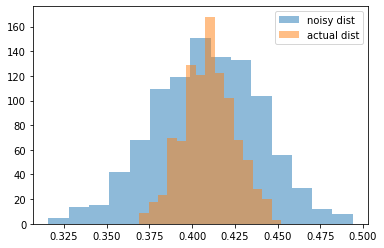

In [63]:
p = approx_p(data)
show_hists(p, 0.5)

As one can see from the histogram, having a randomised response mechanism creates some noise around values, and one gets a more spread distribution. However, the noisy and actual distributions both have similar averages. However, since our data is extremely sensitive to a false label due to the vast differences in potential utilities, even a few wrong labels might bring the classifier from good to terrible.

## Step 3:  Outline of a $\epsilon$ -DP rutine on the "repaid" column


The formula for any algorithm being differentially private:

$$\left|\log\frac{\pi(a, x)}{\pi(a, x')}\right| \leq \epsilon$$

In [64]:
data_reg = np.asarray(data[1:10])
data_prime = data_reg.copy()
data_prime[-1] = 1 if data_prime[-1] == 0 else 0

In [65]:
thetas = np.linspace(0.1, 0.5, 20)
ratios = [
    np.fromiter(((randomized_response(data_reg, theta) == data_reg).all() for _ in range(1000)), bool).mean() /
    np.fromiter(((randomized_response(data_prime, theta) == data_reg).all() for _ in range(1000)), bool).mean()
    for theta in thetas
]

In [66]:
%matplotlib inline

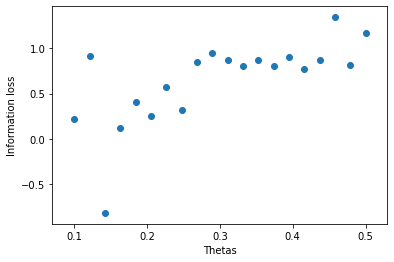

In [67]:
plt.scatter(thetas, np.log(ratios))
plt.xlabel("Thetas")
plt.ylabel("Information loss")
None

In [68]:
import random

An attempt at finding some epsilon. Not very successful.

In [69]:
def check_if_dp_matters(n=100, k=25):
    X, enc, tar = get_data(TRAIN_PATH, drop_cols=True)
    X_te, _, _ = get_data(VALID_PATH, drop_cols=True)
    ir = .017
    dm = AdrianSondreBanker(MultinomialNB())
    dm.set_interest_rate(ir)
    dm.fit(X[enc], X[tar])
    results = []
    random_results = []
    for _ in range(n):
        chunk = X_te.sample(k)
        rand_chunk = chunk.copy()
        idx_to_replace = random.randint(0, k-1)
        rand_chunk.iloc[idx_to_replace] = X_te[~X_te.isin(rand_chunk)].dropna().sample(1).squeeze()
        
        tot_norm, tot_rand = [], []
        tot_norm = dm.model.predict_proba([row for _, row in chunk[enc].iterrows()])
        tot_rand = dm.model.predict_proba([row for _, row in rand_chunk[enc].iterrows()])
        
        norm_class_1, norm_class_2 = np.array(tot_norm)[:,0], np.array(tot_norm)[:,1]
        rand_class_1, rand_class_2 = np.array(tot_rand)[:,0], np.array(tot_rand)[:,1]
        
        results.append(np.log(norm_class_1 / rand_class_1))
        random_results.append(np.log(norm_class_2 / rand_class_2))
    
    return results, random_results

In [70]:
logs, randlogs = check_if_dp_matters()

In [71]:
max([max(l) for l in logs])

38.86441263188985

\pagebreak

# Possible Deficiencies <a id="discussion"></a>

Deploying this model as it is, would pose several problems, of which the biggest are:
- As the data is multiple decades old, it might not be representative of today's loans applicants.
- The distributions of some of the variables were especially uneven. For example, the gender distribution of the training set was ~33% female and ~67% male. In the section on fairness we explain how this did not affect the total utility, but we do not know how it might behave with other data. The same goes for the foreign worker status; ~80% of the records used to train the model were foreign workers, and even though we tried to account for these discrepancies – we cannot guarantee that it will hold in all use cases. Any usage of this model should therefore monitor these things closely to ensure that sensitive variables are not used in credit scores.
- The model development focused on utility. This is of course advantageous from a business point of view, but as a financial institution one might want to adjust the approach so that the decisions fit in a more long-term strategy. 
- Our model, the MultinomailNB, received the highest total utility in our comparison, but not high accuracy in its classifications. This might influence the fairness of the model when the total amount of loan one can grant is limited: Rejecting someone in favor of accepting someone else that might give higher returns is perhaps an economically viable solution, but perhaps not so for the brand of the bank.

Furthermore, although multiple privacy measures were implemented, we cannot guarantee for the privacy of the participants. The routine for k-anonymity (see section) showed that the data contained a lot of distinguishable records. The discussion on privacy shows that implementing K-anonymity in this case was not feasible while at the same time achieving some utility. This is a clear model deficiency that any users should take into account.

# Results

In [72]:
def test_final_model():
    tr_data, enc, tar = get_data(TRAIN_PATH)
    val_data, _, _ = get_data(VALID_PATH)
    test_data, _, _ = get_data(TEST_PATH)
    
    dm = AdrianSondreBanker(MultinomialNB())
    X = pandas.concat([tr_data, val_data])
    X = tr_data
    dm.fit(X[enc], X[tar])
    uti, avg = test_decision_maker(test_data[enc], test_data[tar], 0.017, dm)
    acc = dm.model.score(test_data[enc], test_data[tar])
    return uti, avg, acc

In [73]:
uti, avg, acc = test_final_model()
print(f"Total utility: {uti}")
print(f"Average return: {avg}")
print(f"Model accuracy: {acc}")

Total utility: 54108920.2440422
Average return: 1227.2177919017788
Model accuracy: 0.604


We concatenate the train and validation datasets in order to get more training data before the final test. We have outlined this in the section about reproducibility and reliability. The reason that the total utility is so much higher than the other sets is probably due to a couple of people that loaned money over a very long duration. Our formula results in some extremely high numbers, and it's very possible that up to 30% of the total utility came from a single person, as there are multiple people labelled with _1_ that could potentially do that

# References

Zafar, M. B., Valera, I., Gomez-Rodriguez, M., & Gummadi, K. P. (2019). Fairness Constraints: A Flexible Approach for Fair Classification. J. Mach. Learn. Res., 20(75), 1-42.